In [17]:
import pandas as pd
import os
import geopandas as gp
import numpy as np

In [18]:
inputdir = '/home/mor582/seagrass'
country = 'TH'
cameratype = 'RGB'
dronetype='DJIP4'
surveycode='TKB'
surveynumber=5
timedif = '+07'
inputpath =os.path.join(inputdir,country,f'{surveycode}_{surveynumber:03}')

In [20]:
data = pd.read_csv(f'{inputpath}/{dronetype}_{country}_{surveycode}_{surveynumber:03}_IMG.CSV',
                   index_col='Time',parse_dates=['Time'])
crs = data.iloc[0].Crs

area = gp.read_file(f'{inputpath}/{country}_{surveycode}_surveyarea.shp').to_crs(crs=crs)

In [21]:
p = area.iloc[0].geometry

In [22]:

gdf = gp.GeoDataFrame(
    data, geometry=gp.points_from_xy(data.Easting, data.Northing),
    crs=crs)


In [23]:
from shapely.geometry import Polygon
def to_real_wrold(index,altitude,focallen):
    return (index/focallen)*altitude

def imagecorners(item):
    xw =float(item.ImageWidth)/2
    yw=float(item.ImageHeight)/2
    x = to_real_wrold(np.array([xw,xw,-xw,-xw]),item.RelativeAltitude,3666.666504)
    y = to_real_wrold(np.array([yw,-yw,-yw,yw]),item.RelativeAltitude,3666.666504)
    rads = np.deg2rad(item.FlightYawDegree)
    xx = (x * np.cos(rads) +  y * np.sin(rads))+ item.Easting 
    yy = (-x * np.sin(rads)  +  y  * np.cos(rads))+ item.Northing
    return xx,yy

def make_image_poly(item):
    xx,yy =imagecorners(item)
    return gp.GeoSeries(Polygon(zip(xx,yy)),crs=crs)

gdf['ImagePolygon'] = gdf.apply(make_image_poly,axis=1)


In [24]:
gdf =gdf.set_geometry('ImagePolygon')
gdf['InArea']=gdf.ImagePolygon.apply(lambda x: x.intersects(p))

In [25]:
gdf.to_csv(f'{inputpath}/{dronetype}_{country}_{surveycode}_{surveynumber:03}_IMG_GP.CSV',
                   index=True)

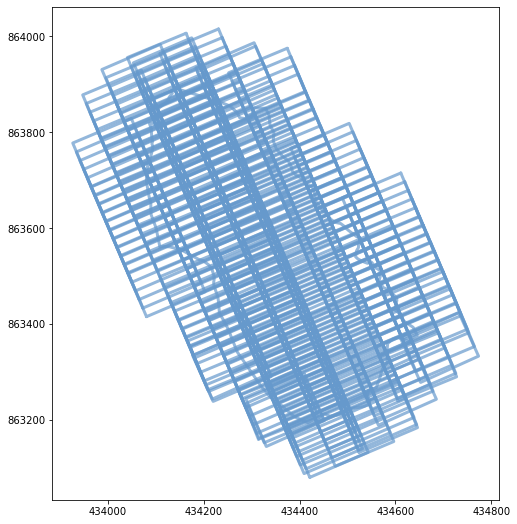

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,20))

for index,row in gdf.iterrows():
    (x,y)=row.ImagePolygon.exterior.xy
    if row.InArea:
        ax.plot(x, y, color='#6699cc', alpha=0.7,
            linewidth=3, solid_capstyle='round', zorder=2)
ax.set_aspect(1)

(x,y)=p.exterior.xy
ax.plot(x, y, color='#6699cc', alpha=0.7,
        linewidth=3, solid_capstyle='round', zorder=2)


In [27]:
data.head()

,SourceFile,ExifToolVersion,FileName,Directory,FileSize,FileModifyDate,FileAccessDate,FileInodeChangeDate,FilePermissions,FileType,...,timedelta,GPSExcessTime,ImageTime,ImageInterval,ImageNorthing,ImageEasting,ImageDistance,ImageSpeed,geometry,ImagePolygon
Time,,,,,,,,,,,,,,,,,,,,,
2018-12-22 17:18:52,/home/mor582/seagrass/TH/TKB_005/DJIP4_TH_TKB_...,10.8,DJIP4_TH_TKB_005_20181222T171852+07_0001.JPG,/home/mor582/seagrass/TH/TKB_005,7.4 MB,2018:12:22 21:18:52+11:00,2020:05:07 17:32:58+10:00,2020:05:07 18:04:05+10:00,rw-rw-r--,JPEG,...,NaN,NaN,2018-12-22 17:18:52.000000000,NaN,863389.850401,434804.375807,NaN,NaN,POINT (434804.376 863389.850),"POLYGON ((434858.0412093098 863451.9563711022,..."
2018-12-22 17:18:56,/home/mor582/seagrass/TH/TKB_005/DJIP4_TH_TKB_...,10.8,DJIP4_TH_TKB_005_20181222T171856+07_0002.JPG,/home/mor582/seagrass/TH/TKB_005,7.1 MB,2018:12:22 21:18:56+11:00,2020:05:07 17:33:00+10:00,2020:05:07 18:04:05+10:00,rw-rw-r--,JPEG,...,2.604086,3.409188e-10,2018-12-22 17:18:56.000000000,4.0,863418.827488,434791.158198,31.849282,7.962321,POINT (434791.158 863418.827),"POLYGON ((434832.9425105478 863490.53344254, 4..."
2018-12-22 17:18:58,/home/mor582/seagrass/TH/TKB_005/DJIP4_TH_TKB_...,10.8,DJIP4_TH_TKB_005_20181222T171858+07_0003.JPG,/home/mor582/seagrass/TH/TKB_005,7.7 MB,2018:12:22 21:18:58+11:00,2020:05:07 17:32:57+10:00,2020:05:07 18:04:05+10:00,rw-rw-r--,JPEG,...,1.953672,-2.273923e-10,2018-12-22 17:18:58.500000000,2.5,863437.105604,434783.510886,19.813402,7.925361,POINT (434783.511 863437.106),"POLYGON ((434825.2951985379 863508.811558217, ..."
2018-12-22 17:19:01,/home/mor582/seagrass/TH/TKB_005/DJIP4_TH_TKB_...,10.8,DJIP4_TH_TKB_005_20181222T171901+07_0004.JPG,/home/mor582/seagrass/TH/TKB_005,7.9 MB,2018:12:22 21:19:02+11:00,2020:05:07 17:32:46+10:00,2020:05:07 18:04:05+10:00,rw-rw-r--,JPEG,...,3.012239,-2.363190e-10,2018-12-22 17:19:01.000000000,2.5,863455.095043,434775.835214,19.558524,7.823410,POINT (434775.835 863455.095),"POLYGON ((434817.3274786343 863526.8746354299,..."
2018-12-22 17:19:03,/home/mor582/seagrass/TH/TKB_005/DJIP4_TH_TKB_...,10.8,DJIP4_TH_TKB_005_20181222T171903+07_0005.JPG,/home/mor582/seagrass/TH/TKB_005,7.8 MB,2018:12:22 21:19:04+11:00,2020:05:07 17:32:55+10:00,2020:05:07 18:04:05+10:00,rw-rw-r--,JPEG,...,1.974031,-3.243277e-10,2018-12-22 17:19:03.500000000,2.5,863473.027943,434768.176274,19.499955,7.799982,POINT (434768.176 863473.028),"POLYGON ((434810.1686400488 863544.5161180535,..."


In [28]:
gdf.to_csv(f'{inputpath}/{dronetype}_{country}_{surveycode}_{surveynumber:03}_IMG_GP.CSV',
                   index=True)